Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3613 - mae: 0.5621
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2707 - mae: 0.4764 
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2020 - mae: 0.4047 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0914 - mae: 0.2521 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0464 - mae: 0.1731 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0678 - mae: 0.2117 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - mae: 0.1586 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0322 - mae: 0.1485 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0371 - mae: 0.1549 
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359 - mae: 0.1456 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299 - mae: 0.1364 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - mae: 0.1247 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

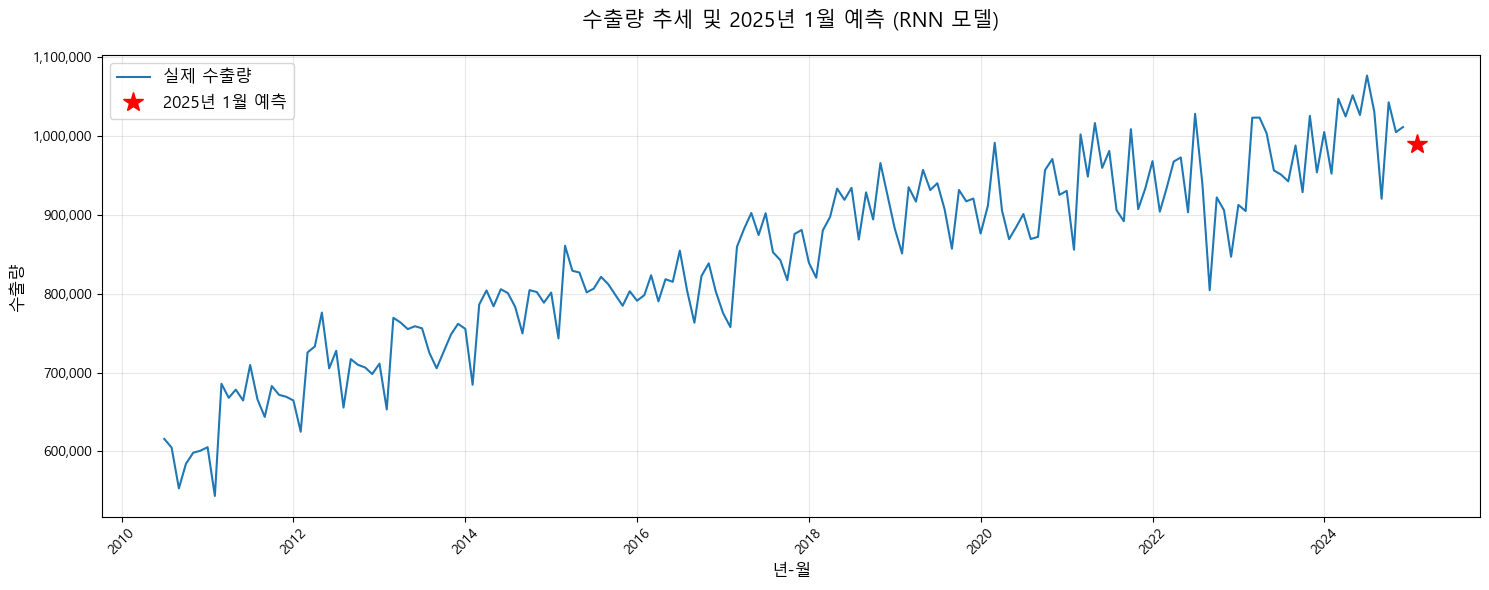

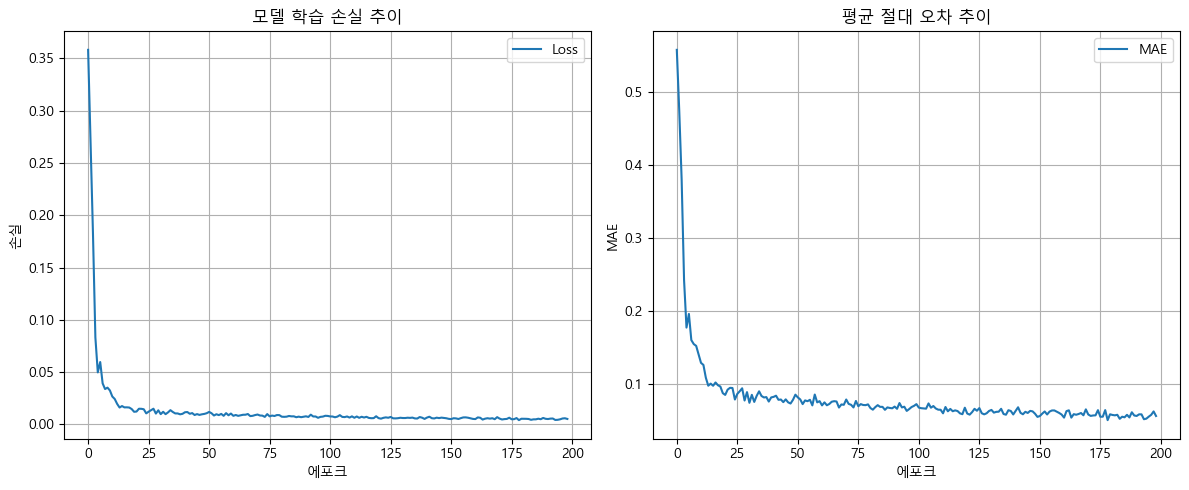

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


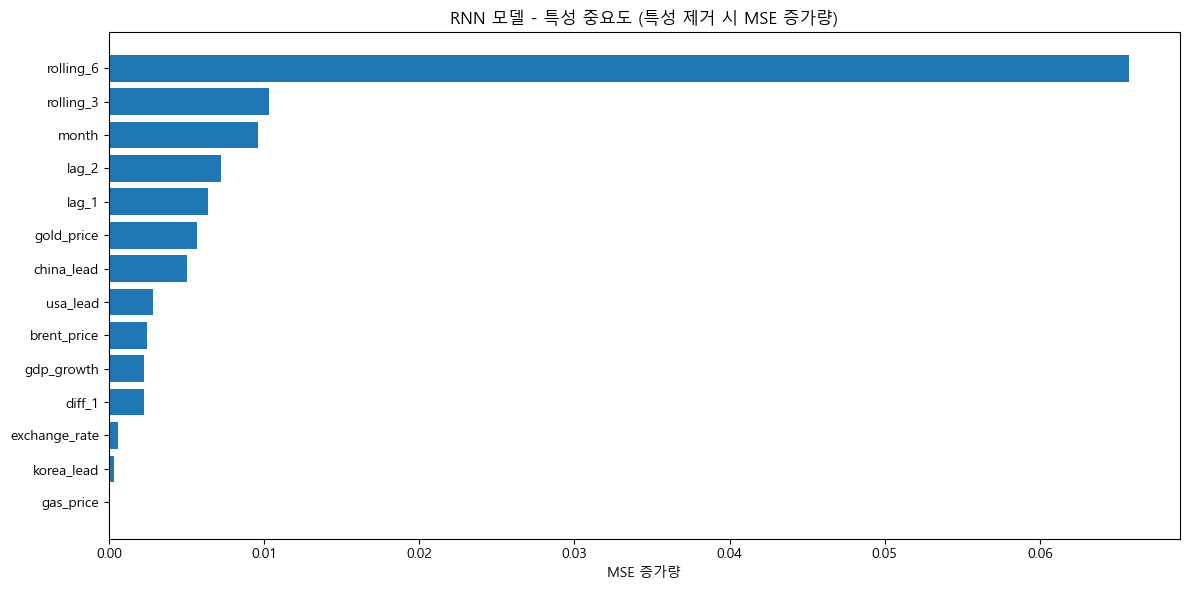

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

모델 성능 지표:
Mean Squared Error: 1,036,369,476.30
Root Mean Squared Error: 32,192.69
Mean Absolute Error: 25,646.38
R2 Score: 0.9200


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ_1.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Lag 및 파생변수 생성
df['lag_1'] = df['export'].shift(1)
df['lag_2'] = df['export'].shift(2)
df['rolling_3'] = df['export'].rolling(window=3).mean().shift(1)
df['rolling_6'] = df['export'].rolling(window=6).mean().shift(1)  # 6개월 이동평균 추가
df['diff_1'] = df['export'].diff(1).shift(1)
df['month'] = df.index.month  # 월별 계절성 추가

# 결측치 처리
df = df.dropna()

# 특성과 타겟 분리
features = ['gdp_growth', 'korea_lead', 'brent_price', 'exchange_rate', 
           'gold_price', 'gas_price', 'usa_lead', 'china_lead',
           'lag_1', 'lag_2', 'rolling_3', 'rolling_6', 'diff_1', 'month']
X = df[features]
y = df['export']

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# RNN을 위한 시퀀스 데이터 준비
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# RNN 모델 구성
model = Sequential([
    LSTM(64, activation='relu', input_shape=(time_steps, X.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early Stopping 설정
early_stopping = EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# 전체 데이터로 모델 학습
history = model.fit(X_seq, y_seq, 
                   epochs=200, 
                   batch_size=32, 
                   callbacks=[early_stopping],
                   verbose=1)

# 2025년 1월 예측을 위한 데이터 준비
last_sequence = X_scaled[-time_steps:]
last_sequence = last_sequence.reshape(1, time_steps, X.shape[1])

# 2025년 1월 수출량 예측
prediction_scaled = model.predict(last_sequence)
prediction_2025_01 = scaler_y.inverse_transform(prediction_scaled)[0][0]

print("\n2025년 1월 수출량 예측:")
print(f"예측 수출량: {prediction_2025_01:,.0f}")

# 과거 데이터와 예측값 시각화
plt.figure(figsize=(15, 6))

# 과거 실제 수출량
plt.plot(y.index, y, linestyle='-', label='실제 수출량', color='#1f77b4')

# 2025년 1월 예측값
future_date = pd.date_range(start=y.index[-1], periods=2, freq='M')[1]
plt.plot([future_date], [prediction_2025_01], marker='*', 
         markersize=15, linestyle='none', label='2025년 1월 예측', color='red')

plt.title('수출량 추세 및 2025년 1월 예측 (RNN 모델)', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 학습 손실 및 MAE 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('모델 학습 손실 추이')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE')
plt.title('평균 절대 오차 추이')
plt.xlabel('에포크')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 변수 중요도 분석
importance = []
base_pred = model.predict(X_seq)
base_mse = np.mean((y_seq - base_pred) ** 2)

for feature_idx in range(X.shape[1]):
    X_temp = X_seq.copy()
    X_temp[:, :, feature_idx] = 0
    pred = model.predict(X_temp)
    mse = np.mean((y_seq - pred) ** 2)
    importance.append(mse - base_mse)

# 변수 중요도 시각화
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({
    '특성': features,
    '중요도': importance
})
importance_df = importance_df.sort_values('중요도', ascending=True)

plt.barh(importance_df['특성'], importance_df['중요도'])
plt.title('RNN 모델 - 특성 중요도 (특성 제거 시 MSE 증가량)')
plt.xlabel('MSE 증가량')
plt.tight_layout()
plt.show()

# 모델 성능 지표 출력
# 전체 데이터에 대한 예측
all_sequences = create_sequences(X_scaled, y_scaled, time_steps)[0]
predictions_scaled = model.predict(all_sequences)
predictions = scaler_y.inverse_transform(predictions_scaled)
actual = scaler_y.inverse_transform(y_seq)

mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print("\n모델 성능 지표:")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"Root Mean Squared Error: {rmse:,.2f}")
print(f"Mean Absolute Error: {mae:,.2f}")
print(f"R2 Score: {r2:.4f}")